In [1]:
import torch
print(torch.cuda.is_available()) # should be True
# t = torch.rand(10, 10).cuda()
# print(t.device) # should be CUDA]
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torchio as tio
from typing import List, Tuple
from numpy import ndarray
from nilearn.image import resample_to_img
from sklearn.model_selection import StratifiedKFold

True


## TEST 2D slices with tagged tumors!

#### single image test

In [31]:
def convert_3d_into_2d(nifti_image: ndarray) -> ndarray:
    slices = []
    
    # Extract slices along the first dimension (axial)
    for i in range(nifti_image.shape[0]):
        slices.append(nifti_image[i, :, :])
    
    # Extract slices along the second dimension (coronal)
    for i in range(nifti_image.shape[1]):
        slices.append(nifti_image[:, i, :])
    
    # Extract slices along the third dimension (sagittal)
    for i in range(nifti_image.shape[2]):
        slices.append(nifti_image[:, :, i])
    print(len(slices))
    print(slices[0].shape)
    print(slices[1].shape)
    print(slices[2].shape)
    print(slices[433].shape)
    return slices

test = convert_3d_into_2d(head_nifti.get_fdata())

AttributeError: 'numpy.ndarray' object has no attribute 'get_fdata'

In [34]:
# https://neuroimaging-data-science.org/content/005-nipy/003-transforms.html

head_nifti = nib.load('data/processed/preop/BTC-preop/sub-PAT08/t1_ants_aligned.nii.gz')
mask_nifti = nib.load('data/raw/preop/BTC-preop/derivatives/tumor_masks/sub-PAT08/anat/sub-PAT08_space_T1_label-tumor.nii')
mask_resampled = resample_to_img(mask_nifti, head_nifti, interpolation='nearest')

head_affine = head_nifti.affine
mask_affine = mask_resampled.affine
print(nib.aff2axcodes(head_affine))
print(nib.aff2axcodes(mask_affine))

('L', 'A', 'S')
('L', 'A', 'S')


In [35]:
def normalize_nifti(nifti_image: nib.Nifti1Image) -> ndarray:
    return (nifti_image.get_fdata() - np.min(nifti_image.get_fdata())) / (np.max(
        nifti_image.get_fdata()) - np.min(nifti_image.get_fdata()))

# head_nifti = normalize_nifti(head_nifti)
# mask_resampled = normalize_nifti(mask_resampled)
head_nifti = head_nifti.get_fdata()
mask_resampled = mask_resampled.get_fdata()

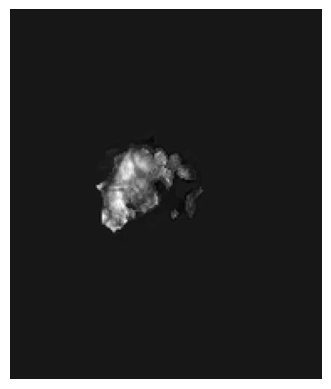

In [38]:

# def check_tumor_missing(slice_2d: ndarray, threshold=0.1):
#     return np.any(slice_2d >= threshold)

# print(check_tumor_missing(mask_resampled[30, ...]))
plt.imshow(head_nifti[10, ...], cmap='gray')

# Plot the mask in red color with low opacity
# plt.imshow(mask_resampled[10, ...],cmap='Reds', alpha=0.7)

# Show the plot
plt.axis('off')
plt.show()

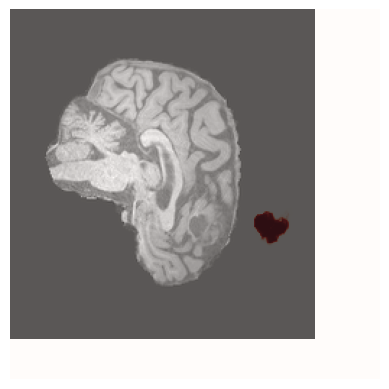

In [18]:
new_img = nib.Nifti1Image(head_nifti.get_fdata(), mask_affine, head_nifti.header)
new_img = new_img.get_fdata()
image_data_normalized = (new_img - np.min(new_img)) / (np.max(new_img) - np.min(new_img))
mask_data_normalized = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
# Plot the image
plt.imshow(image_data_normalized[75, :, :], cmap='gray')

# Plot the mask in red color with low opacity
plt.imshow(mask_data_normalized[75, :, :], cmap='Reds', alpha=0.3)

# Show the plot
plt.axis('off')
plt.show()

### All images test

In [2]:

def stratified_kfold_split(dataset, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    splits = list(skf.split(range(len(dataset)), dataset.labels))
    return splits

def normalize_nifti(nifti_image: nib.Nifti1Image) -> ndarray:
    return (nifti_image.get_fdata() - np.min(nifti_image.get_fdata())) / (np.max(
        nifti_image.get_fdata()) - np.min(nifti_image.get_fdata()))

def pad_slice(slice_2d: ndarray, output_size=(256, 256)) -> ndarray:
    """
    Pad a 2D slice to the desired output size with zeros.
    """
    pad_height = (output_size[0] - slice_2d.shape[0])
    pad_width = (output_size[1] - slice_2d.shape[1])
    
    padded_slice = np.pad(slice_2d, 
                          ((0, pad_height), (0, pad_width)), 
                          mode='constant', 
                          constant_values=0)
    return padded_slice

def slice_has_high_info(slice_2d: np.ndarray, value_minimum=0.15, percentage_minimum=0.05):
    total_cells = slice_2d.size
    num_high_info_cells = np.count_nonzero(slice_2d >= value_minimum)
    percentage_high_info = num_high_info_cells / total_cells
    return percentage_high_info > percentage_minimum

def balance_classes_slices():
    return

def convert_3d_into_2d(nifti_image: ndarray, skip: int =1) -> list[Tuple[ndarray, Tuple[int, int, int]]]:
    slices = []
   
    # (axial)
    ## TODO: Use all slices for now only using every 4th slices
    for i in range(nifti_image.shape[0]):
        if i % skip == 0:
            slices.append((nifti_image[i, :, :], (i, None , None)))
    #  (coronal)
    for i in range(nifti_image.shape[1]):
        if i % skip == 0:
            slices.append((nifti_image[:, i, :], (None, i, None)))  
    # (sagittal)
    for i in range(nifti_image.shape[2]):
        if i % skip == 0:
            slices.append((nifti_image[:, :, i], (None, None, i)))
    return slices

def has_tumor_cells(slice_2d: ndarray, threshold=0.15):
    return np.any(slice_2d >= threshold)


In [8]:

class imagePairs(Dataset):
    """
    Image dataset for each subject in the dataset
    creating only 'correct' and 'incorrect' pairs for now

    Works by passing preop or postop directory to the class
    and finds the corresponding image in the other dir and labels
    """
    def __init__(self, proc_preop: str, raw_tumor_dir: str, image_ids: list, transform=None, skip:int=1,
                 tumor_sensitivity = 0.10):
        self.root = proc_preop
        self.transform = transform
        self.data = []
        self.labels = []
        self.image_ids = image_ids
        for root, dirs, files in os.walk(self.root):
            for filename in files:
                for image_id in self.image_ids:
                    if filename.endswith(image_id):
                        try:
                            pat_id = root.split("/")[-1]
                            print(f"Processing {pat_id}")
                            preop_nifti = nib.load(os.path.join(root, filename))
                            postop_nifti = nib.load(os.path.join(root.replace("preop", "postop"), 
                                                                filename.replace("preop", "postop")))
                            # load the tumor from the tumor directory matching the patient id
                            if "PAT" in pat_id:
                                try:
                                    tumor = nib.load(os.path.join(f"{raw_tumor_dir}/{pat_id}/anat/{pat_id}_space_T1_label-tumor.nii"))
                                    tumor_resampled = resample_to_img(tumor, preop_nifti, interpolation='nearest')
                                    tumor_norm = normalize_nifti(tumor_resampled)
                                except FileNotFoundError as e:
                                    print(f"Tumor not found for {pat_id}, {e}")
                                except Exception as e:
                                    print(f"Uncaught error, {e}")
                            
                            # resample the postop nifti to the preop nifti
                            preop_nifti_norm = normalize_nifti(preop_nifti)
                            postop_nifti_norm = normalize_nifti(postop_nifti)

                            if "-CON" in pat_id:
                                assert preop_nifti_norm.shape == postop_nifti_norm.shape
                                
                                images_pre = convert_3d_into_2d(preop_nifti_norm, skip=skip)
                                images_post = convert_3d_into_2d(postop_nifti_norm, skip = skip)

                                # Create triplets with label 1 (similar slices)
                                images_pre_pad = [(pad_slice(image[0]), image[1], 1) for image in images_pre]
                                images_post_pad = [(pad_slice(image[0]), image[1], 1) for image in images_post]
                                
                                assert len(images_pre_pad) == len(images_post_pad)
                                
                                # Create triplets (pre_slice, post_slice, label, tumor=None)
                                triplets_con = [{"pre": pre, "post": post, "label": label, "tumor": np.zeros_like(pre), 
                                                 "pat_id": pat_id, "index_pre": index_pre, "index_post": index_post} 
                                                for (pre, index_pre, label), 
                                                (post, index_post, _) in 
                                                zip(images_pre_pad, images_post_pad) if 
                                                slice_has_high_info(pre) and slice_has_high_info(post)]
                                self.data.extend(triplets_con)
                                self.labels.extend([label for (_, label, _) in images_post_pad])
                            elif "-PAT" in pat_id:
                                assert preop_nifti_norm.shape == postop_nifti_norm.shape == tumor_norm.shape

                                images_pre = convert_3d_into_2d(preop_nifti_norm, skip=skip)
                                images_post = convert_3d_into_2d(postop_nifti_norm, skip=skip)
                                mask_slices = convert_3d_into_2d(tumor_norm, skip=skip)
                                # Create triplets with label 0 if the slice contains a tumor
                                images_pre_pad = [(pad_slice(image[0]), image[1], 0 if has_tumor_cells(mask_slice[0], threshold=tumor_sensitivity) else 1) for image, mask_slice in zip(images_pre, mask_slices)]
                                images_post_pad = [(pad_slice(image[0]), image[1], 0 if has_tumor_cells(mask_slice[0], threshold=tumor_sensitivity) else 1) for image, mask_slice in zip(images_post, mask_slices)]
                                # pad the tumor mask as well
                                mask_slices_pad = [(pad_slice(mask_slice[0]), mask_slice[1]) for mask_slice in mask_slices]
                                assert len(images_pre_pad) == len(images_post_pad) == len(mask_slices_pad)
                                
                                # Create triplets (pre_slice, post_slice, label, tumor)
                                triplets_pat = [{"pre": pre, "post": post, "label": label, "tumor": mask_slice, 
                                                 "pat_id": pat_id, "index_pre": index_pre, "index_post": index_post} 
                                                for (pre, index_pre, label), (post, index_post, _), (mask_slice, _) in 
                                                zip(images_pre_pad, images_post_pad, mask_slices_pad) if 
                                                slice_has_high_info(pre) and slice_has_high_info(post)]
                                self.data.extend(triplets_pat)
                                self.labels.extend([label for (_, label, _) in images_post_pad])
                        except FileNotFoundError as e:
                            print(f"{e}, this is normal to happen for 3 subjects which have no postoperative data")
                        except Exception as e:
                            print(f"Uncaught error, {e}")
                    else:
                        pass
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):

        if self.transform:
            pass
            # img1_file = self.transform(self.data[idx][0])
            # img2_file = self.transform(self.data[idx][1])
        return self.data[idx]
                

In [9]:
   ##TODO: add root path to args.pars because this wont run on server
subject_images = imagePairs(proc_preop='./data/processed/preop/BTC-preop', 
                raw_tumor_dir='./data/raw/preop/BTC-preop/derivatives/tumor_masks',
                image_ids=['t1_ants_aligned.nii.gz'], skip=2, tumor_sensitivity=0.10)
train_subject_images, val_subject_images, test_subject_images = random_split(subject_images, (0.6, 0.2, 0.2))

Processing sub-CON09
Processing sub-CON03
Processing sub-PAT25
Processing sub-PAT05
Processing sub-CON02
Processing sub-PAT26
Processing sub-PAT16
Processing sub-PAT01
Processing sub-PAT24
Processing sub-PAT13
Processing sub-CON06
Processing sub-PAT02
Processing sub-CON08
Processing sub-PAT10
Processing sub-CON04
Processing sub-PAT17
Processing sub-PAT07
Processing sub-CON11
Processing sub-CON07
Processing sub-PAT15
Processing sub-PAT08
Processing sub-CON10
Processing sub-PAT23
Processing sub-PAT20
Processing sub-PAT06
Processing sub-CON05
Processing sub-PAT03
Processing sub-PAT11
Processing sub-PAT28


In [10]:
train_loader = DataLoader(train_subject_images, batch_size=1, shuffle=False)


In [12]:
for i in train_subject_images:
    print(i)
    break

{'pre': array([[0.14102803, 0.14102803, 0.14102803, ..., 0.        , 0.        ,
        0.        ],
       [0.14102803, 0.14102803, 0.14102803, ..., 0.        , 0.        ,
        0.        ],
       [0.14102803, 0.14102803, 0.14102803, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]]), 'post': array([[0.08995386, 0.08995386, 0.08995386, ..., 0.        , 0.        ,
        0.        ],
       [0.08995386, 0.08995386, 0.08995386, ..., 0.        , 0.        ,
        0.        ],
       [0.08995386, 0.08995386, 0.08995386, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        

In [11]:
for index, subject in enumerate(train_loader):
    print(subject)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

In [215]:
print(f"Total number of images: {len(subject_images)}")
for image in subject_images:
    assert image['pre'].shape == image['post'].shape
    assert image['index_post'] == image['index_pre']
    assert image['tumor'].shape == image['pre'].shape
    assert image['tumor'].shape == image['post'].shape
    print(image['index_pre'])

    break

Total number of images: 1163
(20, None, None)


In [3]:
head_nifti = nib.load('data/processed/preop/BTC-preop/sub-PAT11/t1_ants_aligned.nii.gz')
mask_nifti = nib.load('data/raw/preop/BTC-preop/derivatives/tumor_masks/sub-PAT11/anat/sub-PAT11_space_T1_label-tumor.nii')

head = head_nifti.get_fdata()
mask = mask_nifti.get_fdata()

sub-PAT26
0
True


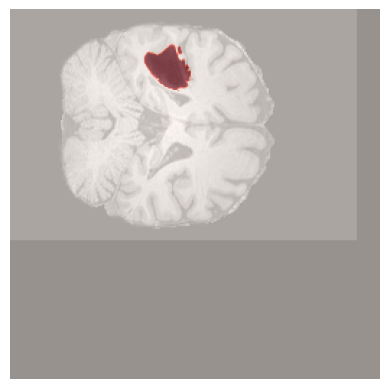

In [221]:
test = subject_images[215]
test['index_pre']
print(test['pat_id'])
print(test['label'])
print(slice_has_high_info(test['pre'], value_minimum=0.15, percentage_minimum=0.05))
# print(test['pre'])
plt.imshow(test['pre'], cmap='gray')

# Plot the mask in red color with low opacity
plt.imshow(test['tumor'],cmap='Reds', alpha=0.6)
#plt.imshow(test['post'], cmap='Reds', alpha=0.3)
# Show the plot
plt.axis('off')
plt.show()

In [201]:
np.set_printoptions(precision=300, threshold=np.inf)
test['tumor']


array([[0.                  , 0.                  , 0.                  , 0.                  ,
        0.                  , 0.                  , 0.                  , 0.                  ,
        0.                  , 0.                  , 0.                  , 0.                  ,
        0.                  , 0.                  , 0.                  , 0.                  ,
        0.                  , 0.                  , 0.                  , 0.                  ,
        0.                  , 0.                  , 0.                  , 0.                  ,
        0.                  , 0.                  , 0.                  , 0.                  ,
        0.                  , 0.                  , 0.                  , 0.                  ,
        0.                  , 0.                  , 0.                  , 0.                  ,
        0.                  , 0.                  , 0.                  , 0.                  ,
        0.                  , 0.        

In [96]:
np.set_printoptions(precision=np.inf, threshold=np.inf)

# Print the array
print(test['pre'])

[[0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.14698588986009894 0.14698588986009894 0.14698588986009894 0.14698588986009894
  0.146985889860

False


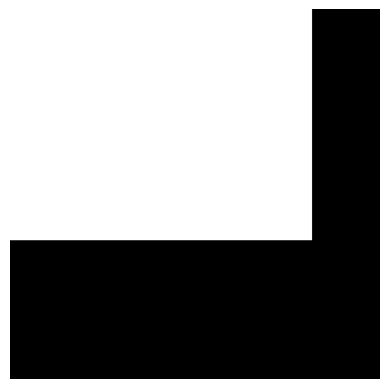

In [44]:
tumor = image['tumor']
print(has_tumor_cells(tumor))
plt.imshow(image['pre'], cmap='gray')

# Plot the mask in red color with low opacity
# plt.imshow(tumor,cmap='Reds', alpha=0.3)
# plt.imshow(image['post'], cmap='gray')
# Show the plot
plt.axis('off')
plt.show()

### tasks
- check heatmap relibaility through tests

## Test heatmap reliability

In [ ]:

def various_distance(out_vec_t0, out_vec_t1,dist_flag):
    if dist_flag == 'l2':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=2)
    if dist_flag == 'l1':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=1)
    if dist_flag == 'cos':
        distance = 1 - F.cosine_similarity(out_vec_t0, out_vec_t1)
    return distance

In [ ]:
def various_distance1(tensor_a, tensor_b, dist_type):
    """Compute a simple squared difference assuming 'l2' means Euclidean."""
    if dist_type == 'l2':
        return (tensor_a - tensor_b) ** 2
    else:
        raise ValueError("Unsupported distance type")

In [ ]:
pdist = nn.PairwiseDistance(p=2)
input1 = torch.zeros([100, 128, 12])
input2 = torch.randn(100, 128, 12)
print(input1.shape  , input2.shape)
print(pdist(input1, input2))
print(various_distance1(input1, input2, 'l2'))
print(various_distance(input1, input2, 'l2'))

torch.Size([100, 128, 12]) torch.Size([100, 128, 12])
tensor([[2.4469, 2.9400, 3.8676,  ..., 3.3183, 4.2914, 1.9747],
        [3.9285, 3.9510, 4.0567,  ..., 3.2019, 2.7593, 3.6369],
        [3.5884, 4.1240, 3.3622,  ..., 3.6095, 3.6335, 4.3030],
        ...,
        [3.2054, 2.0570, 3.9920,  ..., 1.9317, 3.5473, 2.9166],
        [2.7090, 3.6352, 2.6369,  ..., 3.6173, 3.9989, 3.1419],
        [3.7298, 4.1061, 3.8887,  ..., 3.9809, 2.5687, 3.4002]])
tensor([[[4.7407e-02, 8.8523e-01, 1.5144e-02,  ..., 2.7562e+00,
          4.1148e-05, 3.8451e-01],
         [1.0194e+00, 6.5983e-01, 3.8207e-02,  ..., 7.7936e-01,
          1.0567e-01, 8.5427e-02],
         [3.1662e+00, 3.2037e-01, 8.6825e-01,  ..., 8.9877e-01,
          8.7908e-05, 1.2134e-01],
         ...,
         [4.2171e+00, 2.4773e+00, 1.5125e-01,  ..., 1.5934e-02,
          6.5643e-01, 2.5160e-02],
         [5.4381e+00, 2.6042e-01, 2.6415e+00,  ..., 3.0122e+00,
          1.5180e+00, 1.2626e-01],
         [5.7844e-02, 2.1081e-01, 2.725

In [ ]:
# Create synthetic data where the distance should be easy to validate

output_t0 = torch.zeros((1, 1, 10, 10, 10))
output_t1 = torch.zeros_like(output_t0)
output_t0[0, 0, 5, 5, 5] = 1  # Set a single point to a high value
print("Output tensor shape:", output_t0.shape)
# Assume various_distance measures something like Euclidean distance from this point
# This block is pseudo-code; adapt it to your actual `various_distance` implementation
distance = various_distance1(output_t0, output_t1, 'l2')
print("Max distance should be at the corners of the grid:", distance.max())
print(distance.shape)
distance_torch = various_distance(output_t0, output_t1, 'l2')
print("Max distance should be at the corners of the grid:", distance_torch.max())
print(distance_torch.shape)
# Check upsampling and reshaping
similar_distance_map = distance.view(10, 10, 10).data.cpu().numpy()
print("Shape after view, should be (10, 10, 10):", similar_distance_map.shape)

# Perform upsampling and check
interp = nn.Upsample(size=[20, 20, 20], mode='trilinear')
upsampled = interp(torch.from_numpy(similar_distance_map).unsqueeze(0).unsqueeze(0))
print("Shape after upsampling, should be (20, 20, 20):", upsampled.shape)


Output tensor shape: torch.Size([1, 1, 10, 10, 10])
Max distance should be at the corners of the grid: tensor(1.)
torch.Size([1, 1, 10, 10, 10])
Max distance should be at the corners of the grid: tensor(1.0000)
torch.Size([1, 1, 10, 10])
Shape after view, should be (10, 10, 10): (10, 10, 10)
Shape after upsampling, should be (20, 20, 20): torch.Size([1, 1, 20, 20, 20])


In [ ]:
# Create synthetic data where the distance should be easy to validate

output_t0 = torch.zeros((1, 1, 10, 10, 10))
output_t1 = torch.zeros_like(output_t0)
output_t0[0, 0, 5, 5, 5] = 1  # Set a single point to a high value
print("Output tensor shape:", output_t0.shape)
# Assume various_distance measures something like Euclidean distance from this point
# This block is pseudo-code; adapt it to your actual `various_distance` implementation
distance = various_distance1(output_t0, output_t1, 'l2')
print("Max distance should be at the corners of the grid:", distance.max())
print(distance.shape)
distance_torch = various_distance(output_t0, output_t1, 'l2')
print("Max distance should be at the corners of the grid:", distance_torch.max())
print(distance_torch.shape)
# Check upsampling and reshaping
similar_distance_map = distance.view(10, 10, 10).data.cpu().numpy()
print("Shape after view, should be (10, 10, 10):", similar_distance_map.shape)

# Perform upsampling and check
interp = nn.Upsample(size=[20, 20, 20], mode='trilinear')
upsampled = interp(torch.from_numpy(similar_distance_map).unsqueeze(0).unsqueeze(0))
print("Shape after upsampling, should be (20, 20, 20):", upsampled.shape)


Output tensor shape: torch.Size([1, 1, 10, 10, 10])
Max distance should be at the corners of the grid: tensor(1.)
torch.Size([1, 1, 10, 10, 10])
Max distance should be at the corners of the grid: tensor(1.0000)
torch.Size([1, 1, 10, 10])
Shape after view, should be (10, 10, 10): (10, 10, 10)
Shape after upsampling, should be (20, 20, 20): torch.Size([1, 1, 20, 20, 20])


(1000000,)
(101, 101, 101)


/home/adil/Documents/TUE/preparationPhase/myProject/.conda/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/adil/Documents/TUE/preparationPhase/myProject/.conda/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


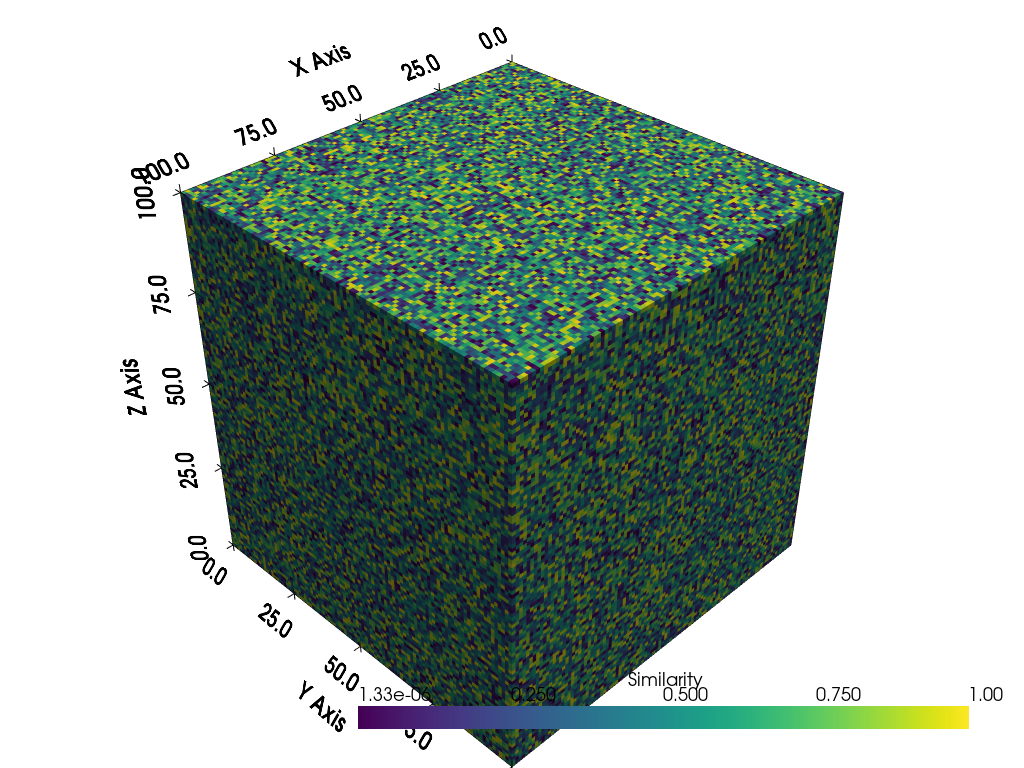

In [ ]:
import numpy as np

import pyvista as pv
data = np.random.rand(100, 100, 100)  # Replace this with your actual 3D array data
similar_distance_map_rz = data
grid = pv.ImageData(dimensions=np.array(similar_distance_map_rz.shape)+1)  # Create an empty grid()
print(similar_distance_map_rz.flatten(order="F").shape)
print(grid.dimensions)
grid.cell_data["Similarity"] = similar_distance_map_rz.flatten(order="F")

# Create a plotter object and set the grid as the active scalar field
plotter = pv.Plotter()
plotter.add_mesh(grid, scalars="Similarity")
plotter.show_grid()
plotter.show()

## Test split

In [ ]:
from sklearn.model_selection import LeaveOneOut
import os
def create_subject_pairs(root, id):
    data = []
    for root, dirs, files in os.walk(root):
        for filename in files:
            for image_id in id:
                if filename.endswith(image_id):
                    nifti_1 = tio.ScalarImage(os.path.join(root, filename))
                    try:
                        if "preop" in root:
                            nifti_2 = tio.ScalarImage(os.path.join(root.replace("preop", "postop"), filename.replace("preop", "postop")))
                        else:
                            nifti_2 = tio.ScalarImage(os.path.join(root.replace("postop", "preop"), filename.replace("postop", "preop")))
                        if "-CON" in filename or "-CON" in os.path.join(root, filename):
                            # print("control for ", filename)
                            data.append(
                                tio.Subject(
                                    t1=nifti_1,
                                    t2=nifti_2,
                                    label=1,
                                    name= root.split("/")[-1],
                                    path= os.path.join(root, filename)
                                            )
                                    )
                        elif "-PAT" in filename or "-PAT" in os.path.join(root, filename):
                                data.append(
                                tio.Subject(
                                    t1=nifti_1,
                                    t2=nifti_2,
                                    label=0,
                                    name= root.split("/")[-1],
                                    path= os.path.join(root, filename)
                                            )
                                    )
                        else:
                            print(f"Invalid filename: {os.path.join(root, filename)}")
                    except FileNotFoundError:
                        print(f"Matching subject (pre and post) not found for {os.path.join(root, filename)}")
    return data



def transform_subjects(subjects: list[tio.Subject]) -> tio.SubjectsDataset:
    transforms = [
    # tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.CropOrPad((164, 164, 164)),
    ]
    transform = tio.Compose(transforms)
    return tio.SubjectsDataset(subjects, transform=transform)

def create_loaders(dataset: Dataset, split=(0.6, 0.2, 0.2), generator=None):
    train_t1, val_t1, test_t1 = random_split(dataset=dataset, lengths=split, generator=generator)
    BATCH_SIZE=1
    train_loader_t1 = DataLoader(train_t1, batch_size=BATCH_SIZE, shuffle=False)
    val_loader_t1 = DataLoader(val_t1, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_t1 = DataLoader(test_t1, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader_t1, val_loader_t1, test_loader_t1

In [ ]:
subjects_raw= create_subject_pairs(root= './data/processed/preop/BTC-preop', id=['t1_ants_aligned.nii.gz'])
subjects = transform_subjects(subjects_raw)
train_loader_t1, val_loader_t1, test_loader_t1 = create_loaders(subjects, split=(0.6, 0.2, 0.2), generator=torch.Generator().manual_seed(42))


In [ ]:
for i in range(5):
    print(i)

0
1
2
3
4


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(skf.split(subjects, [subject.label for subject in subjects])):
    subjects_train = [subjects[i] for i in train_index]
    subjects_val_test = [subjects[i] for i in test_index]
    print(f"  Train: index={train_index}")
    print(f"  Val_test: index={test_index}")
    print("--------")
    subjects_val, subjects_test = train_test_split(subjects_val_test, test_size=0.5, random_state=42, stratify=[subject.label for subject in subjects_val_test])
    val_indices = []
    for subject_val in subjects_val:
        for j, subject in enumerate(subjects):
            if subject.name == subject_val.name:  # Assuming 'name' is the identifier
                val_indices.append(j)
                break
    
    print("  Val:", val_indices)
    
    # Find matching indices in subjects dataset for subjects_test
    test_indices = []
    for subject_test in subjects_test:
        for j, subject in enumerate(subjects):
            if subject.name == subject_test.name:  # Assuming 'name' is the identifier
                test_indices.append(j)
                break
                
    print("  Test:", test_indices)
    print("--------")
    
    # print(f"  Train: index={train_index}")
    # print(f"  Val: index={val_index}")
    # print(f"  Test: index={test_index_new}")

  Train: index=[ 0  2  3  4  6  7  8  9 12 13 14 15 17 18 19 20 21 23 24 25 26 27 28]
  Val_test: index=[ 1  5 10 11 16 22]
--------
  Val: [22, 10, 11]
  Test: [5, 16, 1]
--------
  Train: index=[ 0  1  2  3  4  5  7  8  9 10 11 12 13 16 17 18 19 20 22 25 26 27 28]
  Val_test: index=[ 6 14 15 21 23 24]
--------
  Val: [24, 21, 15]
  Test: [6, 23, 14]
--------
  Train: index=[ 0  1  3  5  6  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25 26 28]
  Val_test: index=[ 2  4  7  8 18 27]
--------
  Val: [27, 18, 7]
  Test: [2, 8, 4]
--------
  Train: index=[ 0  1  2  3  4  5  6  7  8 10 11 14 15 16 17 18 21 22 23 24 26 27 28]
  Val_test: index=[ 9 12 13 19 20 25]
--------
  Val: [20, 25, 13]
  Test: [9, 19, 12]
--------
  Train: index=[ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 27]
  Val_test: index=[ 0  3 17 26 28]
--------
  Val: [17, 3]
  Test: [26, 28, 0]
--------


In [ ]:
subjects_labels= [subject.label for subject in subjects]
for index, i in enumerate(subjects):
    print(i.label == subjects_labels[index])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
